# Preconfiguring the IDE (Предварительная настройка среды разработки)

## Installing the required libraries (Установка необходимых библиотек)

Для локальной среды разработки:

In [90]:
# !conda install -y -c conda-forge optuna
# !conda install -y -c plotly plotly
# !conda install -y -c conda-forge scikit-image
# !conda install -y -c ipython-autotime
# !conda install -c conda-forge imgaug
# !conda install -c conda-forge albumentations
# !conda install -c conda-forge torchmetrics
# !pip install opencv-python
# !conda install -y -c conda-forge onnx
# !conda install -y -c conda-forge onnxruntime
# !conda install -y -c anaconda memory_profiler

Solving environment: done

## Package Plan ##

  environment location: /home/artyom/miniconda3/envs/pytorch-1.13.0

  added / updated specs:
    - memory_profiler


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    memory_profiler-0.58.0     |     pyhd3eb1b0_0          30 KB  anaconda
    ------------------------------------------------------------
                                           Total:          30 KB

The following NEW packages will be INSTALLED:

  memory_profiler    anaconda/noarch::memory_profiler-0.58.0-pyhd3eb1b0_0 None

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2022.9.2~ --> anaconda::ca-certificates-2022.07.19-h06a4308_0 None
  certifi            conda-forge/noarch::certifi-2022.9.24~ --> anaconda/linux-64::certifi-2022.6.15-py39h06a4308_0 None
  openssl              pkgs/main::openssl-1.1.1

Для Google Collab:

In [ ]:
# !pip install optuna
# !pip install ipython-autotime
# !pip install plotly
# # !pip install -U albumentations
# !pip install torchmetrics

## Importing necessary libraries (Импорт необходимых библиотек)

In [71]:
# Вспомогательные бибилотеки
import os
import errno
import time
import copy
import warnings
import multiprocessing
import gc
from datetime import datetime
from pathlib import Path

# Библиотеки используемые для глубокого обучения

import numpy as np

# Pytorch
import torch

## Слои нейронных сетей
import torch.nn as nn

## Оптимизаторы градиентного спуска
import torch.optim as optim

## Загрузка, преобразование датасетов
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

## Используемые нейронные сети
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torchvision.models import resnet152, ResNet152_Weights
from torchvision.models import densenet201, DenseNet201_Weights

## Квантизация моделей
import torch.quantization

## Метрика качества модели
from torchmetrics import Accuracy


from sklearn import metrics
from sklearn.metrics import classification_report


# Оптимизация гиперпараметров
import optuna

## Визуализация оптимизации гиперпараметров
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_contour

## Работа с изображениями
import cv2
from PIL import Image

# ONNX
import onnx
import onnxruntime
import torch.onnx

# Профилирование использования памяти
# from memory_profiler import memory_usage


# Увеличение числа примеров с помощью Albumentation
# import albumentations as A
# import cv2

time: 1.1 ms (started: 2022-11-28 17:16:45 +03:00)


In [2]:
import torch
print(torch.__version__)

1.13.0


## Load dataset (Загрузка датасета)

Для Google Collab:

In [3]:
# # Подключим диск Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip /content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_2/Homework_6/Dataset/Dataset.zip -d /content/

# !rm -rf /content/images/images

# data_dir = './images'

# print("Data loading complete.")

Для локального ПК:

На локальном ПК данные уже распакованны в нужную папку, укажем путь к датасету:

In [4]:
# !unzip ./Dataset.zip -d ./
# !rm -rf /content/images/images

# Путь к датасету
data_dir = './images'

## Setting up the development environment (Настройка среды разработки)

In [5]:
# Настройка среды разработки

# Определим наличие графического ускорителя. Если доступен - используем.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current PyTorch device is set to", device)

# Количество рабочих процессов, зависи от CPU
system_num_workers = multiprocessing.cpu_count()
print("The number of workers processes is set at", system_num_workers)


# Настройка расширения ipython-autotime выводящего время выполнения ячейки.
%load_ext autotime

# Отключим вывод предупреждений FutureWarning 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Для воспроизводимости результата зададим параметр генератора случайных чисел
torch.manual_seed(17)

# Размер батча (пачки) одновременно загружаемых в GPU изображений
batch_size=4

Current PyTorch device is set to cuda:0
The number of workers processes is set at 16
time: 1.11 ms (started: 2022-11-28 13:02:10 +03:00)


## Additional Functions (Дополнительные функции)

Для загруки предварительно обученной модели по ее имени будем использовать функцию `get_model()`:

In [6]:
def get_model(model_name: str = "resnet50", output_class_count = 3):
    model_name = model_name.lower()
    
    if model_name == "resnet50":
    
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
    
        # У этой нейронной сети слои имеют названия, последний слой назвается "fc".
        # Получим количество входных признаков для последнего полносвязного слоя
        in_features = model.fc.in_features

        # Отключаем обновление параметров для всех слоев
        for param in model.parameters():
            param.requires_grad = False

        # Заменим последний полносвязный слой на новый, с необходимым нам 
        # количеством выходов и возможностью обновлением параметров
        model.fc = nn.Linear(in_features, output_class_count)

    elif model_name == "resnet152":

        model = models.resnet152(weights=ResNet152_Weights.DEFAULT, progress=True)

        in_features = model.fc.in_features

        for param in model.parameters():
            param.requires_grad = False

        model.fc = nn.Linear(in_features, output_class_count)

    elif model_name == "resnext50_32x4d":
        # Аналогично "resnet50" слои имеют названия.

        model = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)
    
        # Получим количество входных признаков для последнего полносвязного слоя
        in_features = model.fc.in_features
        
        for param in model.parameters():
            param.requires_grad = False
    
        # Заменим последний полносвязный слой на новый, с необходимым нам 
        # количеством выходов
        model.fc = nn.Linear(in_features, output_class_count)

    elif model_name == "mobilenet_v3_large":
        # У этой нейронной сети последним является блок слоев c названием "classifier".
        # В этом блоке именно последний слой отвечает за количество классов.
        # Внутри блока у слоев нет имен, тольько номера.
  
        model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT, progress=True)
    
        # Получим количество входных признаков для последнего полносвязного слоя
        in_features = model.classifier[3].in_features

        # Заменим последний полносвязный слой на новый, с необходимым нам 
        # количеством выходов и возможностью обновлением параметров
        for param in model.features.parameters():
            param.requires_grad = False

        # Заменим последний полносвязный слой на новый, с необходимым нам 
        # количеством выходов и возможностью обновлением параметров
        model.classifier[3] = nn.Linear(in_features, output_class_count)

    elif model_name == "densenet201":

        model = models.densenet201(weights=DenseNet201_Weights.DEFAULT, progress=True)

        in_features = model.classifier.in_features

        for param in model.parameters():
            param.requires_grad = False

        model.classifier = nn.Linear(in_features, output_class_count)
    
    # Добавим в возвращаемую модель еще один параметр - имя модели
    # Будем использовать его для сохранения лучшей модели.
    model.name = model_name

    return model

time: 1.25 ms (started: 2022-11-28 13:02:12 +03:00)


Функция для получения необученной модели по ее названию:

In [7]:
def get_untrained_model(model_name: str = "resnext50_32x4d", output_class_count = 3):
    if model_name == "resnext50_32x4d":
        # Аналогично "resnet50" слои имеют названия.

        model = torchvision.models.resnext50_32x4d(progress=True)
    
        # Получим количество входных признаков для последнего полносвязного слоя
        in_features = model.fc.in_features
        
        for param in model.parameters():
            param.requires_grad = False
    
        # Заменим последний полносвязный слой на новый, с необходимым нам 
        # количеством выходов
        model.fc = nn.Linear(in_features, output_class_count)
    return model

time: 512 µs (started: 2022-11-28 13:02:13 +03:00)


Доработанная версия `train_model()`

In [8]:
def train_model(trial, model, criterion, optimizer, num_epochs=5):
    
    # Запомним время начала обучения/валидации модели
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Создадим счётчик точности модели
    best_acc = 0.0

    # Итерируемся по эпохам
    for epoch in range(num_epochs):
      
      # Время начаала эпохи
      since_epoch = time.time()

      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      # Сначала обучаем модель, затем оцениваем (валидируем)
      for phase in ['train', 'validation']:
        if phase == 'train':
          model.train()           # Переводим модель в режим обучения
        else:
          model.eval()            # Переводим  модель в режим валидации (оценки качества)
            
        # Обнуляем счётчики для текущего цикла обучения/валидации 
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in data_loaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
                
          # обнуляем градиент
          optimizer.zero_grad()
                
          # Если текущий цикл - цикл обучения, то включаем расчёт градиента
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
              loss.backward()   # bаckpropagation (вычисление градиентов)
              optimizer.step()  # обновление весов сети

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
                
        # Расчитываем потери и accuracy текущей эпохи, и выводим их
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, 
                                                   epoch_acc))
        
        # Выведем время затраченное на обчуение/валидацию в рамках текущей эпохи
        time_epoch_elapsed = time.time() - since_epoch
        print('{} complete in {:.0f}m {:.0f}s'.format(phase, 
                                                      time_epoch_elapsed // 60, 
                                                      time_epoch_elapsed % 60))

        # Если во время валидации в данной эпохи получили модель качеством лучше, то сохраняем её в RAM
        if phase == 'validation' and epoch_acc > best_acc:
          print("Saving new best model with accuracy", epoch_acc)  
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
          file_path = "./" + str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S-")) + model.name + "-accuracy_" + str(best_acc.item()) + ".pt"
          torch.save(model.state_dict(), file_path)
            
      print()
        
      trial.report(epoch_acc, epoch)

      # Если текущее исследование должно быть обрезано, то обрезаем его
      if trial.should_prune():
        raise optuna.TrialPruned()

    # Общее время затраченное на обучение/валидацию модели
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
     
    
    print(file_path)
    
    torch.save(model.state_dict(), file_path)
    
    # DEBUG
    # print("FUNC train_model, model type :", type(model))
    
    return model, best_acc

time: 1.85 ms (started: 2022-11-28 13:02:13 +03:00)


Так как обьем видеопамяти небольшой (4 GB), необходимо очищать видеопамять после завершения каждого цикла обучения модели с помощью функции `clear_cuda_cache()`:

In [9]:
def clear_cuda_cache():
    torch.cuda.empty_cache()
    gc.collect()

time: 293 µs (started: 2022-11-28 13:02:14 +03:00)


Функция получения предсказания от модели для одиночного файла:

In [10]:
def get_prediction(image_path, model):
    # Функция предполагает что модель уже находится на CUDA
    image = cv2.imread(image_path)
    image = Image.fromarray(image)
    image = data_transforms['validation'](image)  # Трансформируем изображение, с помощью тех же трансформаций что использовались для валидационного набора изображений.
    image = torch.unsqueeze(image, 0)             # Добавим еще одно измерение
    image = image.to(device)
    pred = model(image)
    
    return pred

time: 412 µs (started: 2022-11-28 13:02:15 +03:00)


Функция получения предсказания модели для валидационного датасета:

In [11]:
def predict(model, loader):
    true_labels = []
    predicted_labels = []
    dataiter = iter(loader)
    with torch.no_grad():
        for batch in dataiter:
            x, y = batch
            true_labels += y.detach().cpu().numpy().tolist()
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            predicted_labels += np.argmax(pred.detach().cpu().numpy(), axis=1).tolist()
    return true_labels, predicted_labels

time: 460 µs (started: 2022-11-28 13:02:16 +03:00)


Функция для оценки размера нейронной сети до и после квантизации:

In [12]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

time: 392 µs (started: 2022-11-28 13:02:19 +03:00)


# Data augmentation (Аугментация данных)

## С использованием собственного класса FaceExpressionDataset

Функция для получения списка файлов тренировочной или валидационной части датасета:

In [24]:
def load_images(root_directory):

  # Список путей ко всем файлам данной части датасета
  result_filepaths = []

  # проверим существование переданной нам директории c экземплярами датасета.
  # Это должна быть либо тренировочная, либо валидационная части датасета.
  if not os.path.exists(root_directory):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), root_directory)

  # Проверим существование директорий всех категорий датасета
  ## Список всех категорий датасета
  dataset_category_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

  ## Пути ко всем директориям категорий датасета
  category_paths = [os.path.join(root_directory, category_name) for category_name in dataset_category_names]

  for category_path in category_paths:
    if not os.path.exists(category_path):

      # Если какой-либо категории нет, то завершаем работу исключением
      raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), category_path)
    
  # Найдём пути ко всем файлам всех категорий
  for category_path in category_paths:
    result_filepaths.extend(sorted([os.path.join(category_path, f) for f in os.listdir(category_path)]))

  # Возвращаем результат
  return result_filepaths

time: 723 µs (started: 2022-11-20 18:41:26 +03:00)


Класс реализующий загрузку данных датасета Face expression recognition:

In [25]:
class FaceExpressionDataset(Dataset):
  """Kaggle face expression recognition dataset"""
  # Конструктор класса
  def __init__(self, images_filepaths, transform=None):
    self.images_filepaths = load_images(images_filepaths)
    self.transform = transform
    self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

  # Метод возвращающий размер датасета
  def __len__(self):
    return len(self.images_filepaths)

  # Метод для поддержки индексации датасета.
  def __getitem__(self, idx):
    image_filepath = self.images_filepaths[idx]
    image = cv2.imread(image_filepath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                 # В данном датасете черно-белые файлы, нет смысла конвертировать цветовое пространство.
    

    # В реальных условиях стоит иметь в датасете категорию "other" и
    # использвовать ее как категорию по умолчанию. В нашем случае, будем 
    # использвать по-умолчанию категорию "angry". На случай, если датасет 
    # плохого качества.
    label = "angry"

    category_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

    # Если категория найденна, то перебираем весь список категорий нет смысла.
    # Возвращать в label нужно число, а не имя категории!!!
    for category_name in category_names:
      if category_name in os.path.normpath(image_filepath):
        label = category_names.index(category_name)
        break

    # Применяем трансформации данных
    if self.transform is not None:
      image = self.transform(image)

    return image, label

time: 832 µs (started: 2022-11-20 18:41:26 +03:00)


In [26]:
# Зададим последовательности преобразований изображений
data_transforms = {
    'train': transforms.Compose([                                               # Последовательность преобразований для тренировочной части
        transforms.ToPILImage(),                                               
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),          # Автоматическая аугментация с политикой используемой для датасета IMAGENET. Только для Тренировочной части используется!
        transforms.Resize(224),                                                 # Изменим размер изображения
        transforms.ToTensor(),                                                  # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
    'validation': transforms.Compose([                                          # Последовательность преобразований для валидационной части
        transforms.ToPILImage(),
        transforms.Resize(224),                                                 # Изменим размер изображения
        transforms.ToTensor(),                                                  # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
}

# Создадим данных для датасета
image_datasets = {x: FaceExpressionDataset(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}  #  ВАЖНО! В х имена подпапок датасета! Они же будут именами для частей датасета
                                          
# Создадим загрузчики данных
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=system_num_workers)
              for x in ['train', 'validation']}

# Получим размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

# Получим имена классов
class_names = image_datasets['train'].classes

time: 94.1 ms (started: 2022-11-20 18:41:27 +03:00)


## С использование ImageFolder из Pytorch

In [21]:
# Зададим последовательности преобразований изображений
data_transforms = {
    'train': transforms.Compose([                                               # Последовательность преобразований для тренировочной части
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),          # Автоматическая аугментация с политикой используемой для датасета IMAGENET. Только для Тренировочной части используется!
        transforms.Resize(224),                                                 # Изменим размер изображения
        transforms.ToTensor(),                                                  # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
    'validation': transforms.Compose([                                                 # Последовательность преобразований для валидационной части
        transforms.Resize(224),                                                 # Изменим размер изображения
        transforms.ToTensor(),                                                  # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
}

# Создадим данных для датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}  #  ВАЖНО! В х имена подпапок датасета! Они же будут именами для частей датасета
                                          
# Создадим загрузчики данных
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=system_num_workers)
              for x in ['train', 'validation']}

# Получим размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

# Получим имена классов
class_names = image_datasets['train'].classes

time: 112 ms (started: 2022-11-28 13:02:53 +03:00)


In [35]:
class_names 

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

time: 1.82 ms (started: 2022-11-23 16:14:42 +03:00)


# Hyperparameter optimization with Optuna (Оптимизация гиперпараметров с помощью Optuna)

## Creating the objective function (Создание целевой функции)

In [110]:
def objective(trial):

    # Гиперпараметры, которые необходимо оптимизировать в рамках испытания "trial"
    params = {
        "model_name": trial.suggest_categorical('model_name',["resnet152", "resnext50_32x4d", "mobilenet_v3_large"]),  # Список нейронных сетей (категориальный параметр испытаний)
        "learning_rate": trial.suggest_categorical('learning_rate', [0.00001]),                         # Скорость обучения (дискретный параметр).  Два константных значения из списка.
        # "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.0001),                                # Скорость обучения (дискретный параметр). СПОСОБ ЗАДАТЬ ФИКСИРОВАННЫЙ ПАРАМЕТР
        # "learning_rate": trial.suggest_loguniform('learning_rate', 1e-4, 1e-3),                               # Скорость обучения, значение изменяется логарифмически от 0.0001 до 0.001.
        "optimizer_name": trial.suggest_categorical('optimizer_name',["AdamW"])                                 # Оптимизаторы градиентного спуска
        
        # # ОТЛАДКА FaceExpressionDataset()
        # "model_name": trial.suggest_categorical('model_name',["resnet50", "resnext50_32x4d"]),  # Список нейронных сетей (категориальный параметр испытаний)
        # "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.0001),                  # Скорость обучения (дискретный параметр).
        # "optimizer_name": trial.suggest_categorical('optimizer_name',["AdamW"])                 # Оптимизаторы градиентного спуска
    }
    
    # Получение предварительно обученной модели
    model = get_model(params["model_name"], output_class_count = 7)
    model = model.to(device)
    
    # Определим критерий оптимизации используемый для вычисления потерь между входными и целевыми значениями. 
    # Иными словами функция потерь, используемая в оптимизируемых нейронных сетях.
    # Используем кроссэнтропию, так как классификация многоклассовая
    criterion = nn.CrossEntropyLoss()
    
    # Настроим оптимизатор
    optimizer = getattr(
        torch.optim, 
        params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])
    
    # Обучение модели
    best_model, best_acc = train_model(trial, model, criterion, optimizer, num_epochs=10)
    
    # Возвращает точность (целевое значение) текущего испытания
    return best_acc

time: 1.09 ms (started: 2022-11-22 17:08:59 +03:00)


### Tree-structured Parzen Estimator (Оценщик Парзена с древовидной структурой)

In [111]:
sampler = optuna.samplers.TPESampler()    

# Создаем исследование (study), настроим обрезку "плохих" испытаний.
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps = 6), direction='maximize')

# Запускаем процесс исследования (оптимизации гиперпараметров)
study.optimize(func=objective, n_trials=3)

# Выводим номер наиболее оптимального испытания и его гиперпараметры
print("Best trial number: ", study.best_trial.number)
print("Best params:", study.best_trial.params)

[I 2022-11-22 17:09:21,799] A new study created in memory with name: no-name-d5628e7f-8f46-4a95-b407-05134d25cfc3


Epoch 0/9
----------
train Loss: 1.7766 Acc: 0.2695
train complete in 1m 24s
validation Loss: 1.6892 Acc: 0.3391
validation complete in 1m 42s

Epoch 1/9
----------
train Loss: 1.7093 Acc: 0.3143
train complete in 1m 28s
validation Loss: 1.6325 Acc: 0.3728
validation complete in 1m 44s

Epoch 2/9
----------
train Loss: 1.6752 Acc: 0.3358
train complete in 1m 25s
validation Loss: 1.5959 Acc: 0.3890
validation complete in 1m 43s

Epoch 3/9
----------
train Loss: 1.6538 Acc: 0.3434
train complete in 1m 31s
validation Loss: 1.5731 Acc: 0.3987
validation complete in 1m 49s

Epoch 4/9
----------
train Loss: 1.6411 Acc: 0.3497
train complete in 1m 31s
validation Loss: 1.5590 Acc: 0.4090
validation complete in 1m 49s

Epoch 5/9
----------
train Loss: 1.6319 Acc: 0.3521
train complete in 1m 30s
validation Loss: 1.5420 Acc: 0.4106
validation complete in 1m 49s

Epoch 6/9
----------
train Loss: 1.6237 Acc: 0.3598
train complete in 1m 28s
validation Loss: 1.5338 Acc: 0.4203
validation complete in 

[I 2022-11-22 17:27:06,454] Trial 0 finished with value: 0.4289555618454571 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 1e-05, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.4289555618454571.


validation Loss: 1.5100 Acc: 0.4290
validation complete in 1m 44s

Training complete in 17m 44s
Best val Acc: 0.428956
./22_11_2022-17_27_06-mobilenet_v3_large-accuracy_0.4289555618454571.pt
Epoch 0/9
----------
train Loss: 1.8230 Acc: 0.2444
train complete in 2m 26s
validation Loss: 1.7847 Acc: 0.2658
validation complete in 3m 0s

Epoch 1/9
----------
train Loss: 1.7850 Acc: 0.2588
train complete in 2m 26s
validation Loss: 1.7556 Acc: 0.2939
validation complete in 3m 0s

Epoch 2/9
----------
train Loss: 1.7645 Acc: 0.2714
train complete in 2m 25s
validation Loss: 1.7290 Acc: 0.3101
validation complete in 2m 60s

Epoch 3/9
----------
train Loss: 1.7517 Acc: 0.2836
train complete in 2m 27s
validation Loss: 1.7119 Acc: 0.3283
validation complete in 3m 1s

Epoch 4/9
----------
train Loss: 1.7396 Acc: 0.2920
train complete in 2m 26s
validation Loss: 1.6957 Acc: 0.3515
validation complete in 3m 0s

Epoch 5/9
----------
train Loss: 1.7303 Acc: 0.3040
train complete in 2m 26s
validation Loss:

[I 2022-11-22 17:57:57,545] Trial 1 finished with value: 0.37192187942258703 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 1e-05, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.4289555618454571.


Epoch 0/9
----------
train Loss: 1.7760 Acc: 0.2684
train complete in 1m 27s
validation Loss: 1.6902 Acc: 0.3395
validation complete in 1m 45s

Epoch 1/9
----------
train Loss: 1.7072 Acc: 0.3177
train complete in 1m 32s
validation Loss: 1.6329 Acc: 0.3740
validation complete in 1m 51s

Epoch 2/9
----------
train Loss: 1.6773 Acc: 0.3371
train complete in 1m 33s
validation Loss: 1.5974 Acc: 0.3869
validation complete in 1m 52s

Epoch 3/9
----------
train Loss: 1.6561 Acc: 0.3439
train complete in 1m 29s
validation Loss: 1.5747 Acc: 0.3971
validation complete in 1m 47s

Epoch 4/9
----------
train Loss: 1.6430 Acc: 0.3477
train complete in 1m 31s
validation Loss: 1.5573 Acc: 0.4035
validation complete in 1m 49s

Epoch 5/9
----------
train Loss: 1.6300 Acc: 0.3568
train complete in 1m 31s
validation Loss: 1.5427 Acc: 0.4106
validation complete in 1m 50s

Epoch 6/9
----------
train Loss: 1.6245 Acc: 0.3555
train complete in 1m 32s
validation Loss: 1.5340 Acc: 0.4149
validation complete in 

[I 2022-11-22 18:16:09,935] Trial 2 finished with value: 0.42527596943107837 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 1e-05, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.4289555618454571.


validation Loss: 1.5092 Acc: 0.4253
validation complete in 1m 52s

Training complete in 18m 12s
Best val Acc: 0.425276
./22_11_2022-18_16_09-mobilenet_v3_large-accuracy_0.42527596943107837.pt
Best trial number:  0
Best params: {'model_name': 'mobilenet_v3_large', 'learning_rate': 1e-05, 'optimizer_name': 'AdamW'}
time: 1h 6min 48s (started: 2022-11-22 17:09:21 +03:00)


#### Visualization of hyperparameter optimization history (Визуализация истории оптимизации гиперпараметров)

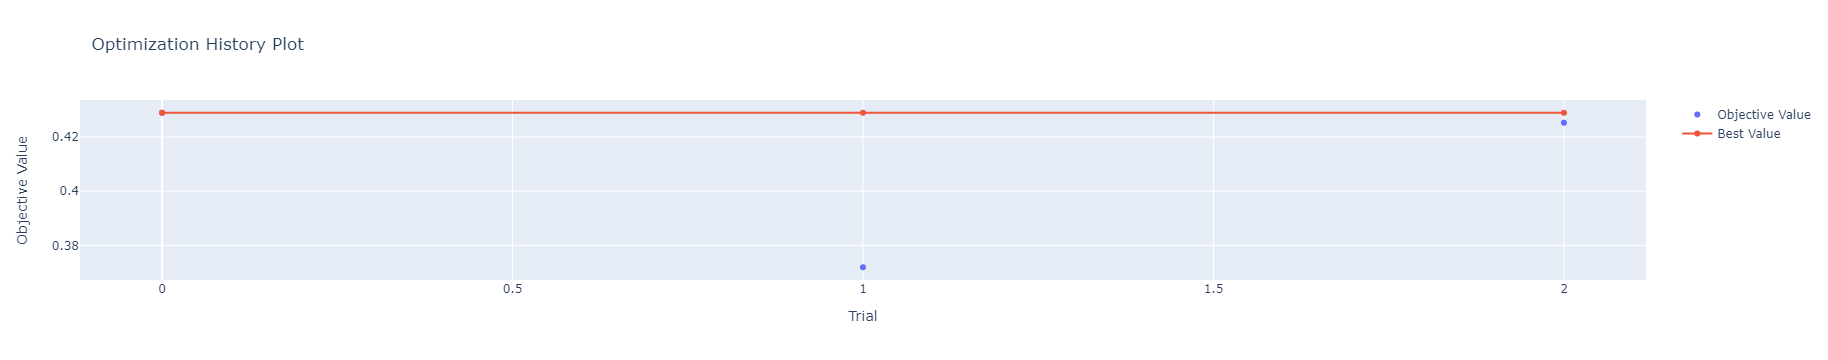

time: 10.5 ms (started: 2022-11-22 18:39:36 +03:00)


In [112]:
plot_optimization_history(study)

#### Visualization of high-dimensional hyperparameter relations (Визуализация высокоразмерных отношений гиперпараметров)

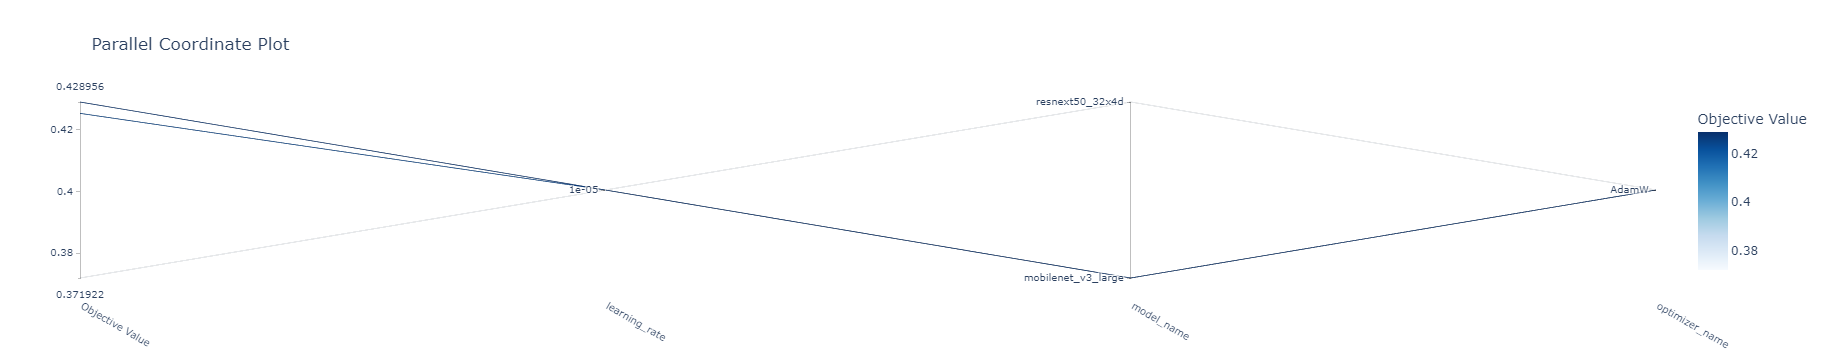

time: 7.56 ms (started: 2022-11-22 18:39:39 +03:00)


In [113]:
plot_parallel_coordinate(study, params=["model_name", "learning_rate", "optimizer_name"])

#### Visualize the learning curves (Визуализация кривых обучения в ходе испытаний)

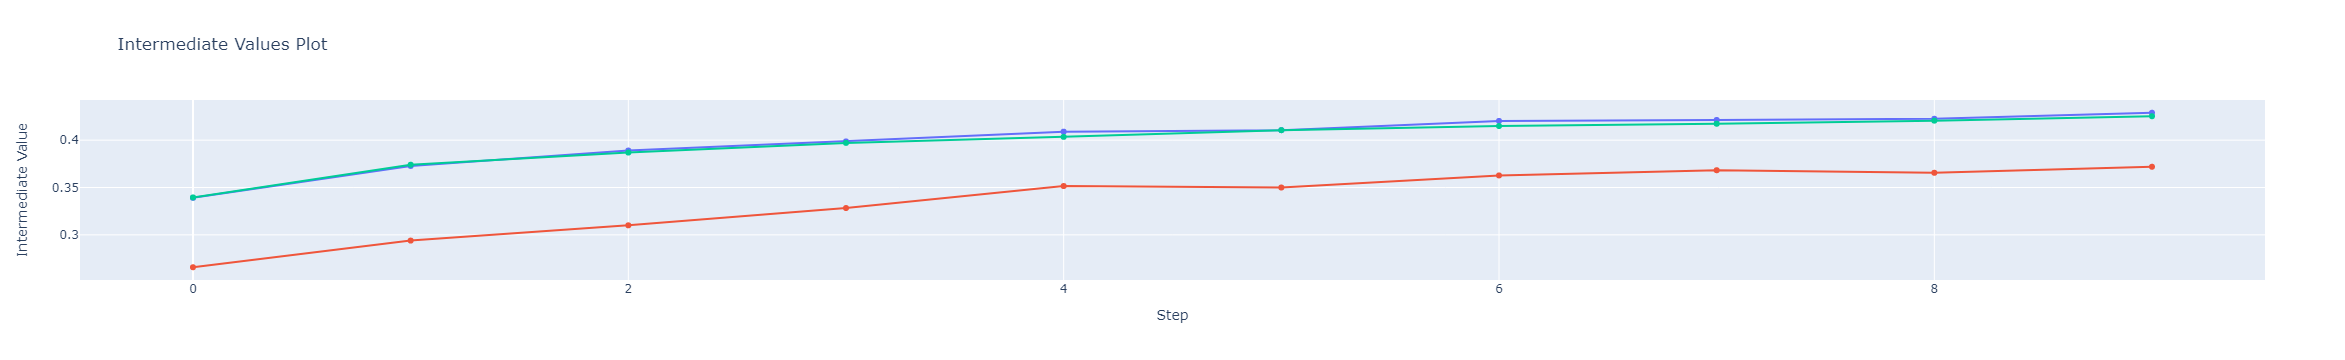

time: 6.38 ms (started: 2022-11-22 18:39:44 +03:00)


In [114]:
plot_intermediate_values(study)

#### Visualize hyperparameter relationships (Визуализация взаимосвязей гиперпараметров)

[W 2022-11-22 18:39:47,858] Param learning_rate unique value length is less than 2.


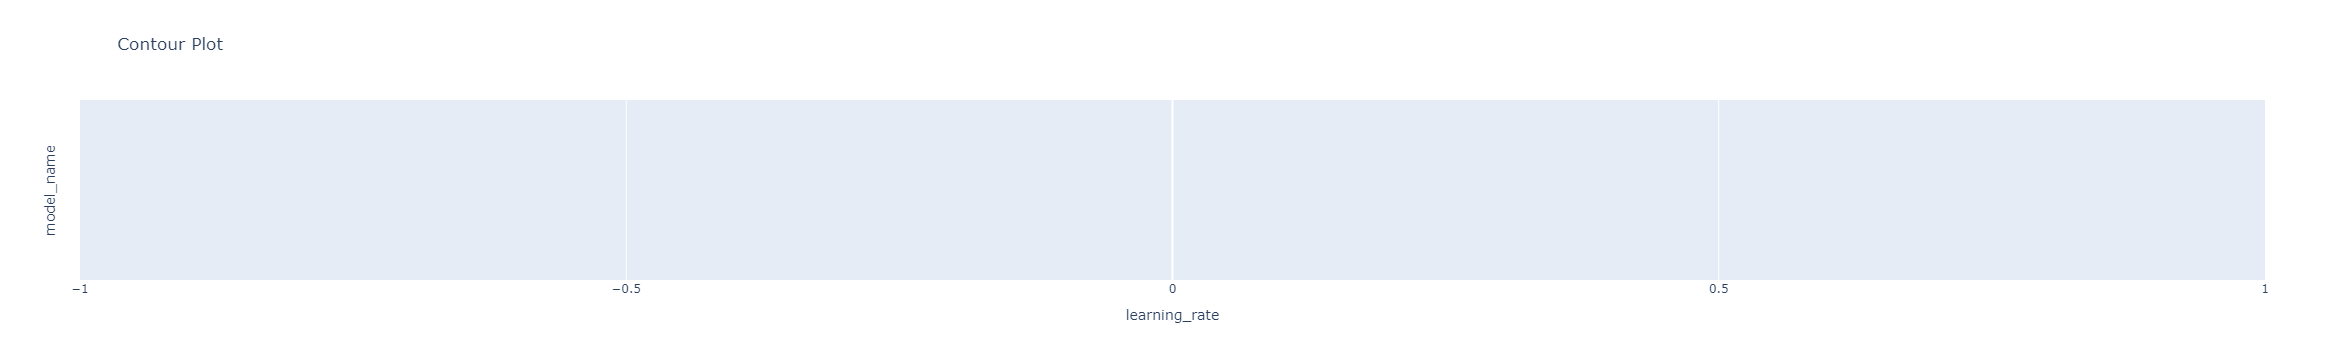

time: 9.29 ms (started: 2022-11-22 18:39:47 +03:00)


In [115]:
plot_contour(study, params=["model_name", "learning_rate"])

#### Визуализация важности гиперпараметров

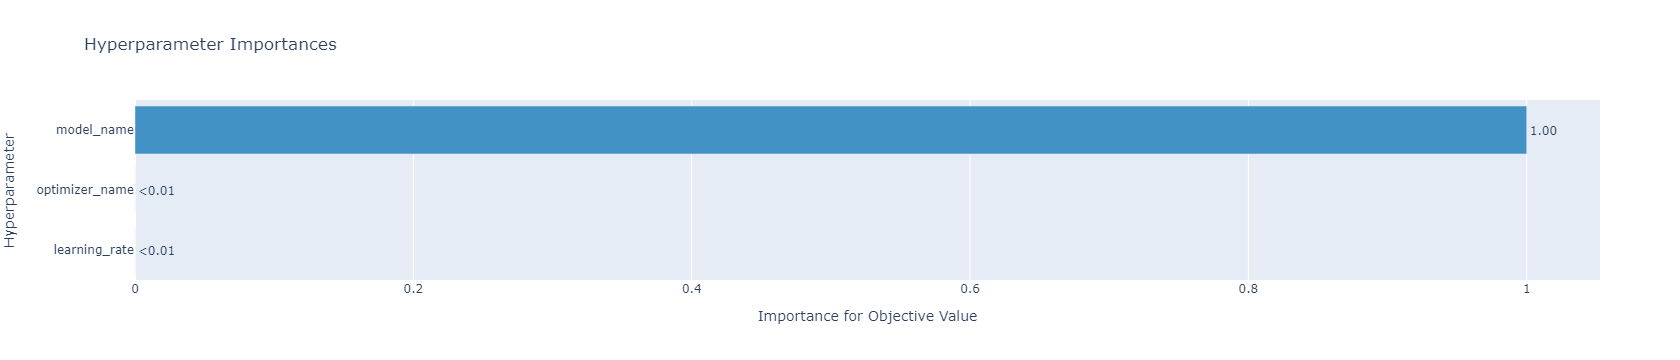

time: 79.2 ms (started: 2022-11-22 18:39:53 +03:00)


In [116]:
plot_param_importances(study)

# Quantization (квантизация модели)

При разработке приложений машинного обучения важно эффективно использовать вычислительные ресурсы как на стороне сервера, так и на конечном устройстве. 
Квантизация использует 8-битные целочисленные (int8) инструкции для уменьшения размера модели и ускорения инференса (за счёт уменьшения задержки).
Даже когда ресурсы аппаратной платформы на которой планируется инференс не столь ограничены, квантизация может позволить развернуть более крупную и точную модель. 

Квантизация относится к методам выполнения как вычислений, так и доступа к памяти с применением данных более низкой точности (обычно `int8`, вместо применяемого `fp32`). 
Это позволяет повысить производительность за счёт:
    - уменьшение размера модели в 4 раза;
    - снижение потребляемой моделью пропускной способности памяти в 2-4 раза;
    - ускорение инференса в 2-4 раза благодаря экономии пропускной способности памяти и ускорению вычислений с помощью арифметики int8 (точное ускорение зависит аппаратной платформы, среды выполнения и модели).
    
Однако квантизация не обходится без дополнительных затрат. По сути, квантизация означает введение приближений, и результирующие нейронные сети имеют немного меньшую точность. 

## Три метода квантизации

Pytorch (начиная с версии 1.3) поддерживает 3 режима квантизации:
- динамическая квантизация. 
- статическая квантизация после обучения.
- квантизация в процессе обучения.


### Динамическая квантизация

Самый простой метод квантизации, поддерживаемый PyTorch, называется динамической квантизацией. Она включает в себя не только преобразование весов в int8 — как это происходит во всех вариантах квантования — но и преобразование 
активаций в int8 на лету, непосредственно перед выполнением вычислений (отсюда и приставка - "динамическая"). Таким образом, вычисления будут выполняться с использованием эффективных реализаций умножения матриц и свертки int8, 
что приведет к более быстрому вычислению. Однако активации считываются и записываются в память в формате с плавающей запятой.

### Статическая квантизация (квантизация после обучения)

Можно дополнительно улучшить производительность (снизить задержку), преобразовав нейронные сети для использования как целочисленной арифметики, так и доступа к памяти int8. Статическое квантизация выполняет дополнительный шаг: 
сначала загружает пакеты данных через нейронную сеть и вычисляет результирующие распределения различных активаций (в частности, это делается путем вставки дополнительных модулей "observers" (наблюдателей) в разные точки нейронной сети,
которые записывают эти распределения). Эта информация используется для определения того, как именно следует квантизировать различные активации во время инференса.

В этой реализации квантизации поддерживаются несколько дополнительных функций, которые позволяют оптимизировать статическое квантование:

1. модули наблюдения (observers): можно настроить модули наблюдения, которые определяют, как собирается статистика перед квантизацией, чтобы опробовать более продвинутые методы квантизации ваших данных.
2. Объединение операторов (operator fusion): можно объединить несколько операций в одну, что позволит сэкономить на доступе к памяти и одновременно повысить точность вычислений.
3. поканальная квантизация (per-channel quantization): можно независимо квантизировать веса для каждого выходного канала в сверточном/линейном слое, что может привести к более высокой точности при почти той же скорости.

### Обучение с квантизацией

Обучение с учетом квантизации (QAT) - это третий метод, который обычно дает самую высокую точность из этих трех методов. В QAT все веса и активации "квантизируются" во время прямого и обратного проходов данных в процессе обучения: то есть, значения float округляются, чтобы имитировать значения int8, но все вычисления по-прежнему производятся с числами с плавающей точкой. Таким образом, все корректировки весов во время обучения производятся с учетом того, что модель 
в конечном итоге будет квантизированна; поэтому после квантизации этот метод обычно дает более высокую точность, чем два других метода.

## Динамическая квантизация оптимальной модели

Так как динамическая квантизация [не полностью поддерживается на GPU](https://discuss.pytorch.org/t/does-dynamic-quantization-support-gpu/119231), переопределим функции для получения прогнозов:

In [13]:
def get_prediction(image_path, model, on_cpu = False):
    # Функция предполагает что модель уже находится на CUDA
    image = cv2.imread(image_path)
    image = Image.fromarray(image)
    image = data_transforms['validation'](image)  # Трансформируем изображение, с помощью тех же трансформаций что использовались для валидационного набора изображений.
    image = torch.unsqueeze(image, 0)             # Добавим еще одно измерение
    if on_cpu:
        image = image.to("cpu")
    else:
        image = image.to(device)
        
    pred = model(image)
    
    return pred

def predict(model, loader, on_cpu = False):
    true_labels = []
    predicted_labels = []
    dataiter = iter(loader)
    with torch.no_grad():
        for batch in dataiter:
            x, y = batch
            true_labels += y.detach().cpu().numpy().tolist()
            
            if on_cpu:
                x = x.to("cpu")
                y = y.to("cpu")
            else:
                x = x.to(device)
                y = y.to(device)
                
            pred = model(x)
            predicted_labels += np.argmax(pred.detach().cpu().numpy(), axis=1).tolist()
            
    return true_labels, predicted_labels

time: 731 µs (started: 2022-11-28 13:02:24 +03:00)


### 1. Загрузим оптимальную модель

In [14]:
# Получим модель сконфигурированную для нашего датасета с весами по умолчанию (ImageNet)
optimal_model = get_untrained_model("resnext50_32x4d", output_class_count = 7)

# Путь к сохраненным весам оптимальной модели полученным не этапе оптимизации гиперпараметров
model_path = "23_11_2022-14_05_42-resnext50_32x4d-accuracy_0.66997.pt"

# Загрузим веса от оптимальной модели
optimal_model.load_state_dict(torch.load(model_path))

# Вызовем model.eval(), чтобы установить dropout and batch normalization слои в режим оценки перед инференсом модели.
optimal_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

time: 1.95 s (started: 2022-11-28 13:02:33 +03:00)


### 2. Динамическая квантизация модели.

Динамическая квантизация поддерживается не для всех типов слоев нейронных сетей. Подробности можно прочитать [здесь](https://pytorch.org/docs/stable/quantization.html). В случае модели "resnext50_32x4d" возможна квантизация только полносвязного слоя `nn.Linear`.

In [15]:
quantized_model = torch.quantization.quantize_dynamic(
    optimal_model, {nn.Linear}, dtype=torch.qint8
)

time: 42.2 ms (started: 2022-11-28 13:02:39 +03:00)


DEBUG

In [16]:
print(next(optimal_model.parameters()).is_cuda)
print(next(quantized_model.parameters()).is_cuda)

False
False
time: 411 µs (started: 2022-11-28 13:02:40 +03:00)


Получим оптимальные гиперпараметры  выбранной ранее модели :

### 3. Определение размера модели до и после квантизации

In [17]:
fp32_model = print_size_of_model(optimal_model,"fp32")

int8_model = print_size_of_model(quantized_model,"int8")

model:  fp32  	 Size (KB): 92332.091
model:  int8  	 Size (KB): 92289.905
time: 140 ms (started: 2022-11-28 13:02:42 +03:00)


Размер модели не сильно уменьшился. Это не удивительно, ведь из всех слоев модели динамически квантизировать можно только выходной слой nn.Linear отвечающий за классификацию. 

### 4. Определение изменения задержки

In [18]:
print("Optimized model in CUDA:", next(optimal_model.parameters()).is_cuda)
print("Quantized model in CUDA:", next(quantized_model.parameters()).is_cuda)

Optimized model in CUDA: False
Quantized model in CUDA: False
time: 416 µs (started: 2022-11-28 13:02:44 +03:00)


Подготовим тестовое изображение:

In [22]:
# Путь к файлу с изображением
image_path = "./10019.jpg"

time: 239 µs (started: 2022-11-28 13:02:58 +03:00)


In [23]:
%timeit get_prediction(image_path, optimal_model, on_cpu=True)

45.3 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 3.72 s (started: 2022-11-28 13:02:58 +03:00)


In [24]:
%timeit get_prediction(image_path, quantized_model, on_cpu=True)

43.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
time: 3.57 s (started: 2022-11-28 13:03:02 +03:00)


Квантизованная модель работает (в среднем) быстрее на 1.3 ms. Это довольно посредственное снижение задержки. Но это не удивительно, квантизация проводилась только для одного выходного слоя.

### 5. Определим изменения в accuracy

Прогноз исходной модели для валидационного датасета:

In [25]:
true_labels, predicted_labels = predict(optimal_model, data_loaders['validation'], on_cpu=True)
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.58      0.56      0.57       960
     disgust       0.66      0.57      0.61       111
        fear       0.55      0.45      0.50      1018
       happy       0.84      0.90      0.87      1825
     neutral       0.61      0.64      0.62      1216
         sad       0.55      0.55      0.55      1139
    surprise       0.77      0.79      0.78       797

    accuracy                           0.67      7066
   macro avg       0.65      0.64      0.64      7066
weighted avg       0.66      0.67      0.67      7066

time: 5min 19s (started: 2022-11-28 13:03:14 +03:00)


Прогноз квантизованной модели для валидационного датасета

In [26]:
true_labels_q, predicted_labels_q = predict(quantized_model, data_loaders['validation'], on_cpu=True)
print(classification_report(true_labels_q, predicted_labels_q, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.58      0.56      0.57       960
     disgust       0.66      0.57      0.61       111
        fear       0.55      0.45      0.50      1018
       happy       0.84      0.90      0.87      1825
     neutral       0.61      0.64      0.62      1216
         sad       0.55      0.55      0.55      1139
    surprise       0.77      0.79      0.78       797

    accuracy                           0.67      7066
   macro avg       0.65      0.64      0.64      7066
weighted avg       0.66      0.67      0.67      7066

time: 5min 42s (started: 2022-11-28 13:08:33 +03:00)


Точности оптимальной и квантизованной моделей совпадают.

## Статическая квантизация (квантизация после обучения)

Этот метод заранее преобразует веса и активации в 8-битные целые числа, что позволяет избежать преобразования активаций "на лету" во время инференса, как это происходит при динамическом квантизации, а значит, значительно повышает производительность.

### 1. Загрузим оптимальную модель

In [64]:
# Получим модель сконфигурированную для нашего датасета с весами по умолчанию (ImageNet)
optimal_model = get_untrained_model("resnext50_32x4d", output_class_count = 7)

# Путь к сохраненным весам оптимальной модели полученным не этапе оптимизации гиперпараметров
model_path = "23_11_2022-14_05_42-resnext50_32x4d-accuracy_0.66997.pt"

# Загрузим веса от оптимальной модели
optimal_model.load_state_dict(torch.load(model_path))

# Вызовем model.eval(), чтобы установить dropout and batch normalization слои в режим оценки перед инференсом модели.
optimal_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

time: 520 ms (started: 2022-11-28 17:13:52 +03:00)


### 2. Статическая квантизация модели после обучения.

Выберем глобальный `qconfig`, который содержит информацию о том, какой тип наблюдений использовать в процессе квантизации. В основном, 'fbgemm' используется  для последующего инференса  квантизованной модели на серверах. 
'qnnpack' используется для мобильных устройств.

In [65]:
backend = "fbgemm"
optimal_model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend


time: 367 µs (started: 2022-11-28 17:13:57 +03:00)


In [66]:
model_static_quantized = torch.quantization.prepare(optimal_model, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)

/home/artyom/miniconda3/envs/pytorch-1.13.0/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/artyom/miniconda3/envs/pytorch-1.13.0/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


time: 382 ms (started: 2022-11-28 17:13:58 +03:00)


### 3. Определение размера модели до и после квантизации

In [67]:
fp32_model = print_size_of_model(optimal_model,"fp32")

int8_model = print_size_of_model(model_static_quantized,"int8")

model:  fp32  	 Size (KB): 92332.091
model:  int8  	 Size (KB): 24184.497
time: 158 ms (started: 2022-11-28 17:14:04 +03:00)


Размер статически квантизованной модели сократился более чем в 3 раза.

### 4. Определение изменения задержки

In [68]:
# Путь к файлу с изображением
image_path = "./10019.jpg"

time: 260 µs (started: 2022-11-28 17:14:11 +03:00)


In [69]:
optimal_model.to(device)
%timeit get_prediction(image_path, optimal_model, on_cpu=False)

The slowest run took 8.63 times longer than the fastest. This could mean that an intermediate result is being cached.
48.6 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
time: 3.28 s (started: 2022-11-28 17:14:12 +03:00)


In [103]:
model_static_quantized.to("cpu")
%timeit get_prediction(image_path, model_static_quantized, on_cpu=True)

NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/quantized/cpu/qconv.cpp:1449 [kernel]
QuantizedCUDA: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/quantized/cudnn/Conv.cpp:418 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/PythonFallbackKernel.cpp:140 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/DynamicLayer.cpp:488 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:291 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/autograd/TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/autocast_mode.cpp:482 [backend fallback]
AutocastCUDA: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/autocast_mode.cpp:324 [backend fallback]
FuncTorchBatched: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:743 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/TensorWrapper.cpp:189 [backend fallback]
PythonTLSSnapshot: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/DynamicLayer.cpp:484 [backend fallback]
PythonDispatcher: registered at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]


time: 72.9 ms (started: 2022-11-28 17:54:58 +03:00)


Измерить задержку статически квантизованной модели тоже не удалось. Такие модели не поддерживаются ни на CPU ни на GPU.

# ONNX

ONNX - сокращение от Open Neural Network Exchange, представляет собой стандартную платформу с открытым исходным кодом, которая позволяет разработчикам переносить модели машинного обучения обученные с помощью различных фреймворков в ONNX.
ONNX поддерживает все популярные платформы машинного обучения, включая Keras, TensorFlow, Scikit-learn, PyTorch и XGBoost. ONNX также позволяет поставщикам аппаратных продуктов, предназначенных для ускорения машинного обучения, сосредоточиться на едином представлении графа ONNX.

ONNX не позволяет разработчикам зацикливаться на каком-либо конкретном фреймворке машинного обучения, предоставляя инструменты, которые позволяют легко переходить от одного к другому. Для этого ONNX делает следующее:

-***Определение расширяемого графа вычислений*** - Изначально различные фреймворки будут иметь различные представления графов. ONNX предоставляет стандартное представление графа для всех них. Граф ONNX представляет граф модели через различные вычислительные узлы и может быть визуализирован с помощью таких инструментов, как Netron.

-***Создание стандартных типов данных*** - Каждый узел в графе обычно имеет определенный тип данных. Для обеспечения совместимости между различными платформами, ONNX определяет стандартные типы данных, включая int8, int16, float16 и другие.

-***Встроенные операторы*** - Эти операторы отвечают за сопоставление типов операторов в ONNX с требуемым фреймворком. Если вы конвертируете модель PyTorch в ONNX, все операторы PyTorch отображаются в соответствующие им операторы в ONNX. Например, операция сигмоиды в PyTorch будет преобразована в соответствующую операцию сигмоиды в ONNX.

-***Предоставление единого формата файлов*** - Каждая библиотека машинного обучения имеет свой собственный формат файлов. Например, модели Keras могут быть сохранены с расширением `.h5`, PyTorch как `.pt`, а модели scikit-learn как файлы pickle. ONNX предоставляет единый стандарт для сохранения и экспорта файлов моделей. Этот формат имеет расширение `.onnx`.

## 1. Загрузим оптимальную модель

Оптимальная модель:

In [73]:
# Получим модель сконфигурированную для нашего датасета с весами по умолчанию (ImageNet)
optimal_model = get_model("resnext50_32x4d", output_class_count = 7)

# Путь к сохраненным весам оптимальной модели полученным не этапе оптимизации гиперпараметров
model_path = "./23_11_2022-21_29_07-resnext50_32x4d-accuracy_0.6987.pt"

# Загрузим веса от оптимальной модели
optimal_model.load_state_dict(torch.load(model_path))

# Вызовем model.eval(), чтобы установить dropout and batch normalization слои в режим оценки перед инференсом модели.
optimal_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

time: 405 ms (started: 2022-11-28 17:17:32 +03:00)


Получим квантизированный вариант оптимальной модели:

In [74]:
quantized_model = torch.quantization.quantize_dynamic(
    optimal_model, {nn.Linear}, dtype=torch.qint8
)

time: 28.2 ms (started: 2022-11-28 17:18:19 +03:00)


> ***ВАЖНО!***    
>
> ***Небоходимо вызвать `model.eval()` для всех моделей, чтобы установить слои dropout и batch normalization в режим оценки перед выполнением вывода. Если этого не сделать, результаты вычислений будут противоречивыми.***

Проверим, переведены ли модели в режим оценки:

In [75]:
print("Optimal model in evaluated mode:", not(optimal_model.training))
print("Quantized model in evaluated mode:", not(quantized_model.training))

Optimal model in evaluated mode: True
Quantized model in evaluated mode: True
time: 638 µs (started: 2022-11-28 17:18:32 +03:00)


## 2. Конвертирование моделей в формат ONNX:

Экспорт модели в PyTorch работает с помощью трассировки или скрипта. Чтобы экспортировать модель, мы вызываем функцию `torch.onnx.export()`. Это приведет к выполнению модели, записывая трассировку того, какие операторы используются для вычисления выходов. 
Поскольку в процесс экспорта запускает модель, нам необходимо предоставить входной тензор `x`. Значения в нем могут быть случайными, если только они имеют правильный тип и размер. Обратите внимание, что размер входа будет фиксированным в экспортированном графе ONNX 
для всех размерностей входа, если он не указан как динамическая ось. Мы экспортируем модель с входом `batch_size=1`, но затем указываем первое измерение как динамическое в параметре `dynamic_axes` в `torch.onnx.export()`. Таким образом, экспортированная модель 
будет принимать входные данные размером [batch_size, 1, 224, 224], где `batch_size` может быть переменной.

> ***ВАЖНО***
>
> ***Конвертирование моделей в ONNX формат не полностью реализованно для динамически квантизованных моделей. Далее будет использована статически квантизованныя после обучения модель.***  


In [76]:
batch_size = 1

# Сгенерируем случайные входные данные для выполнения трассировки
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True) # Модель расчитана на 3 канал разрешениием 224 на 224.

# Вычислим выходные данные моделей, которые мы будем использовать для проверки того, 
# что экспортированная нами модель вычисляет те же значения при запуске в среде выполнения ONNX.
optimal_model_out = optimal_model(x)
quantized_model_out = quantized_model(x)

time: 128 ms (started: 2022-11-28 17:18:51 +03:00)


Выполним экспорт оптимальной модели:

In [77]:
# Export the model
torch.onnx.export(optimal_model,             # модель, которую необходимо экспортировать
                  x,                         # входные данные для трассировки модели (или кортеж для нескольких входов)
                  "optimal_model.onnx",   # имя файла, в который будет сохранена модель (может быть файлом или файло-подобным объектом)
                  export_params=True,        # хранить обученные веса параметров в файле модели
                  opset_version=10,          # версия ONNX для экспорта модели
                  do_constant_folding=True,  # выполнить фолдинг констант для оптимизации
                  input_names = ['input'],   # имена входных данных модели
                  output_names = ['output'], # имена выходных данных модели
                  dynamic_axes={'input' : {0 : 'batch_size'},    # указание, какие оси входных и выхожных данных имеют переменный размер
                                'output' : {0 : 'batch_size'}})

print("Export of the model to ONNX is complete.")

Export of the model to ONNX is complete.
time: 618 ms (started: 2022-11-28 17:18:56 +03:00)


Не квантизованная модель успешно конвертировалась и сохранилась в ONNX формате.

Выполним экспорт квантизованной модели:

In [78]:
# Export the model
torch.onnx.export(quantized_model,             # модель, которую необходимо экспортировать
                  x,                         # входные данные для трассировки модели (или кортеж для нескольких входов)
                  "quantized_model.onnx",   # имя файла, в который будет сохранена модель (может быть файлом или файло-подобным объектом)
                  export_params=True,        # хранить обученные веса параметров в файле модели
                  opset_version=16,          # версия ONNX для экспорта модели
                  do_constant_folding=True,  # выполнить фолдинг констант для оптимизации
                  input_names = ['input'],   # имена входных данных модели
                  output_names = ['output'], # имена выходных данных модели
                  dynamic_axes={'input' : {0 : 'batch_size'},    # указание, какие оси входных и выхожных данных имеют переменный размер
                                'output' : {0 : 'batch_size'}})

print("Export of the model to ONNX is complete.")

UnsupportedOperatorError: Exporting the operator 'quantized::linear_dynamic' to ONNX opset version 16 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues

time: 846 ms (started: 2022-11-28 17:19:03 +03:00)


Квантизованная модель не конвертируется в ONNX. Видимо, такие модели еще не поддерживаются.

## 3. Проверка экспортированных моделей

Перед проверкой вывода модели с помощью ONNX Runtime мы проверим модель ONNX с помощью ONNX API.  Во-первых, загрузим сохраненные модели и выведет структуру `onnx.ModelProto` (формат файла/контейнера верхнего уровня для объединения ML-модели. Более подробную информацию можно найти в документации [onnx.proto](https://github.com/onnx/onnx/blob/master/onnx/onnx.proto).). Затем, с помощью `onnx.checker.check_model(onnx_model)` проверим структуру модели и подтвердим, что модель имеет действительную схему. Достоверность графа ONNX проверяется путем проверки версии модели, структуры графа, а также узлов и их входов и выходов. 

In [81]:
# Загрузим модель и проведем ее проверку
onnx_optimal_model = onnx.load("optimal_model.onnx")
onnx.checker.check_model(onnx_optimal_model)

time: 37.1 ms (started: 2022-11-28 17:19:51 +03:00)


Теперь давайте вычислим результат с помощью Python API ONNX Runtime. Эта часть обычно может быть выполнена в отдельном процессе или на другой машине, но мы продолжим в том же процессе, чтобы проверить, что ONNX Runtime и 
PyTorch вычисляют одно и то же значение для сети. Чтобы запустить модель с помощью ONNX Runtime, нам необходимо создать сессию вывода для модели с выбранными параметрами конфигурации (здесь мы используем конфигурацию по умолчанию). 
После того как сессия создана, мы оцениваем модель с помощью API `run()`. Результатом этого вызова является список, содержащий выходы модели, вычисленные ONNX Runtime.

In [82]:
# Создадим сессию ONNX runtime c параметрами по умолчанию.
ort_session = onnxruntime.InferenceSession("./optimal_model.onnx")

# Функция конвертирования тензора в numpy массив
def to_numpy(tensor):

    if tensor.requires_grad:
        result = tensor.detach().cpu().numpy()
    else:
        result = tensor.cpu().numpy()
        
    return result

# получим прогноз для модели ONNX
# используя заранее подготовленные данные
onnx_input = to_numpy(x)
rt_inputs = {ort_session.get_inputs()[0].name: onnx_input}
ort_outs = ort_session.run(None, rt_inputs)


# Сравним результаты моделей, чтобы убедиться в работоспособности ONNX модели после импорта
# np.testing.assert_allclose вызовет ошибку AssertionError, если два объекта не равны в пределах желаемого допуска.
np.testing.assert_allclose(to_numpy(optimal_model_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Вывод моделей эквивалентен.")

Вывод моделей эквивалентен.
time: 100 ms (started: 2022-11-28 17:19:52 +03:00)


### 3.1 Проверка модели на изображении с помощью ONNX Runtime

В этом раз используем изображение из валидационной части датасета для проверки работоспособности модели:

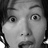

Predicted label for picture: surprise
time: 36.8 ms (started: 2022-11-28 17:19:54 +03:00)


In [83]:
# Откроем тестовое изображение и конвертируем его в RGB
# Наша модель все же является результатом трансферного обучения модели обученной для RGB 
img = Image.open("./images/validation/surprise/10056.jpg").convert('RGB') 

# Применим преобразования, которые использвались для валидационной части датасета
image = data_transforms['validation'](img)

# Добавим еще одно измерение в массив с изображением, в этом измерении будет храниться номер батча
image = torch.unsqueeze(image, 0)

# Получим прогноз от ONNX модели
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
ort_outs = ort_session.run(None, ort_inputs)

# Выведем изображение и прогноз модели ONNX
img.show()
print("Predicted label for picture: {}".format(class_names[np.argmax(ort_outs)]))

In [ ]:
Попробуем другую картинку:

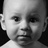

Predicted label for picture: neutral
time: 30.6 ms (started: 2022-11-28 17:42:29 +03:00)


In [95]:
img = Image.open("./images/validation/neutral/10068.jpg").convert('RGB') 

image = data_transforms['validation'](img)
image = torch.unsqueeze(image, 0)

# Получим прогноз от ONNX модели
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
ort_outs = ort_session.run(None, ort_inputs)

# Выведем изображение и прогноз модели ONNX
img.show()
print("Predicted label for picture: {}".format(class_names[np.argmax(ort_outs)]))

## 4. Сравним ONNX модель с моделью Pytorch

In [100]:
print("ONNX model size (kb):", os.path.getsize("./optimal_model.onnx")/1e3)

ONNX model size (kb): 91865.023
time: 507 µs (started: 2022-11-28 17:50:59 +03:00)


Вес модели в формате ONNX практический не отличается от веса Pytorch модели.

Измерим задержку модели во время выполнения предсказания:

In [101]:
%timeit ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}

1.64 µs ± 18.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
time: 13.3 s (started: 2022-11-28 17:53:01 +03:00)


In [ ]:
Но выполнение предсказания ONNX модели выполняется гораздо быстрее - 1.64 микросекунд против 48.6 миллисекунд для оптимальной модели на GPU.

# Выводы

1. Динамическая квантизация подходит не для любой модели, как показал вариант с "resnext50_32x4d".
2. Получаемое снижение задержки и веса модели тоже зависит от конкретной модели.
3. В некоторых случаях, динамическая квантизация может "привязать" квантизованную модель к CPU. Так как модели с квантизацией могут еще не поддерживаться на GPU.
4. Модель в ONNX формате весит столько же, но при этом выполняется быстрее.

# ЧЕРНОВИК

In [ ]:
import torch
from torchmetrics import Accuracy

target = torch.tensor([0, 1, 2, 3])
preds = torch.tensor([0, 1, 1, 3])
accuracy = Accuracy(num_classes = 7, average='weighted')
accuracy(preds, target)

# Дополнительные ссылки

Документация по Pytorch:
- [WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [MODELS AND PRE-TRAINED WEIGHTS](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights)
- [Data Augmentations in Torchvision](https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e)
- [AutoAugment](https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugment.html)
- [SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

Статьи по Optuna:
- [How to make your model awesome with Optuna](https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af)


Документация по Pytorch Metrics:
- [QUICK START](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)
-[STRUCTURE OVERVIEW](https://torchmetrics.readthedocs.io/en/stable/pages/overview.html)
- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)


Albumentation:
- [Демо площадка Albumentation](https://demo.albumentations.ai/)
- [Image augmentation for classification](https://albumentations.ai/docs/getting_started/image_augmentation/)
- [PyTorch and Albumentations for image classification](https://albumentations.ai/docs/examples/pytorch_classification/)

Квантизация нейронных сетей:
- [Введение в квантизацию c Pytorch](https://pytorch.org/blog/introduction-to-quantization-on-pytorch/)
- [Квантизаци, ее типы и какие слои можно квантовать](https://pytorch.org/docs/stable/quantization.html)
- [DYNAMIC QUANTIZATION](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html)
- [Post Training Static Quantization](https://pytorch.org/tutorials/recipes/quantization.html#post-training-static-quantization)
- [Quantizing Resnet50](https://docs.nvidia.com/deeplearning/tensorrt/pytorch-quantization-toolkit/docs/tutorials/quant_resnet50.html)

Optuna:
- [Re-use the best trial](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/010_reuse_best_trial.html)

ONNX:
- [How to Convert a PyTorch Model to ONNX in 5 Minutes](https://deci.ai/blog/how-to-convert-a-pytorch-model-to-onnx/)
- [EXPORTING A MODEL FROM PYTORCH TO ONNX AND RUNNING IT USING ONNX RUNTIME](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)

Дистиляция:
- [knowledge-distillation-pytorch (Github)](https://github.com/haitongli/knowledge-distillation-pytorch)
- [Обзор универсальных оптимизаций нейросетей](https://vc.ru/newtechaudit/517512-obzor-universalnyh-optimizaciy-neyrosetey)